In [ ]:
!nvidia-smi

Sun Aug 14 16:50:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1D:00.0 Off |                  Off |
| 33%   25C    P8     3W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1brDGZFmcFPjTcloSsIs5CCpluAPuTUbg?usp=sharing)


This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program and use Weights & Biases for experiment tracking.

This tutorial is modified from a tutorial from MONAI's official GitHub Repository: [Link](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d_visualization_basic.ipynb)

And easily use below features from MONAI:

- Transforms for dictionary format data.
- Load Nifti image with metadata.
- Add channel dim to the data if no channel dimension.
- Scale medical image intensity with expected range.
- Crop out a batch of balanced images based on positive / negative label ratio.
- Cache IO and transforms to accelerate training and validation.
- 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
- Sliding window inference method.
- Deterministic training for reproducibility.
- The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

# Setup Environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import wandb" || pip install -q wandb
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'wandb'


In [ ]:
import os
import glob
import shutil
import tempfile

import wandb
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

Let's print configuration of some packages by using a utility function provided by MONAI as `print_config()` which basically lists down all the versions of the useful libraries.

In [ ]:
print_config()

MONAI version: 0.10.dev2233
Numpy version: 1.22.2
Pytorch version: 1.11.0a0+17540c5
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a0fe66e4e09b4d8138865ded5df44e78e266e4df
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.2
Pillow version: 9.0.0
Tensorboard version: 2.8.0
gdown version: 4.5.1
TorchVision version: 0.12.0a0
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [ ]:
# set the environment variable
os.environ["MONAI_DATA_DIRECTORY"] = "./output"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./output


# Download the dataset


Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

The website has many types of medical datasets like brain tumor, pancreas, heart, prostrate, etc. Here, we are going to use the spleen dataset. 

The spleen is a fist-sized organ in the upper left side of your abdomen, next to your stomach and behind your left ribs. 

It's an important part of your immune system, but you can survive without it. This is because the liver can take over many of the spleen's functions.

To read more about spleen you can visit [this website](https://www.nhs.uk/conditions/spleen-problems-and-spleen-removal)


First, we will download the data by specifying the link of the data from the website. Furthermore, we will use a hash value to validate the downloaded file. Finally, we will extract the .tar file. Note, how easy it is to do all of the above steps using the function `download_and_extract`

In [ ]:
# define the link of the dataset
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# define the hash value to validate the downloaded file
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
# define the path for downloading the .tar file
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# define the directory for extracting the contents of the .tar file
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    # download, extract and validate the file
    download_and_extract(resource, compressed_file, root_dir, md5)

# Set MSD Spleen dataset path

We will store the image path and label path as a key value pair in a dictionary and split a subset of data for validation.

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

# Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

# Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

# Check DataLoader

Now, we will plot a single slice from the first 3D image from the dataloader along with it's label to see if it is loaded and transformed correctly.

image shape: (228, 158, 113), label shape: (228, 158, 113)


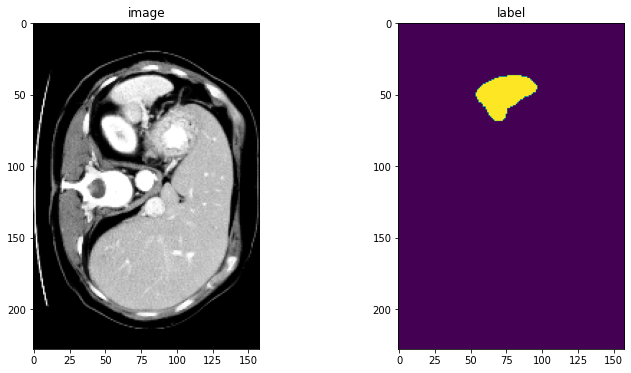

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

Great, now we will create a function which will log all the slices of the 3D image to W&B to visualize them interactively. Furthermore, we will also log the slices with segmentation masks to see the overlayed view of segmentations masks on the slices interactively in the W&B dashboard.

# Logging spleen slices to W&B

In [ ]:
# utility function for generating interactive image mask from components
def wb_mask(bg_img, mask):
    return wandb.Image(bg_img, masks={
    "ground truth" : {"mask_data" : mask, "class_labels" : {0: "background", 1: "mask"} }})

def log_spleen_slices(total_slices=100):
    
    wandb_mask_logs = []
    wandb_img_logs = []

    check_ds = Dataset(data=train_files, transform=val_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader) # get the first item of the dataloader

    image, label = (check_data["image"][0][0], check_data["label"][0][0])
    
    for img_slice_no in range(total_slices):
        img = image[:, :, img_slice_no]
        lbl = label[:, :, img_slice_no]
        
        # append the image to wandb_img_list to visualize 
        # the slices interactively in W&B dashboard
        wandb_img_logs.append(wandb.Image(img, caption=f"Slice: {img_slice_no}"))

        # append the image and masks to wandb_mask_logs
        # to see the masks overlayed on the original image
        wandb_mask_logs.append(wb_mask(img, lbl))

    wandb.log({"Image": wandb_img_logs})
    wandb.log({"Segmentation mask": wandb_mask_logs})

In [ ]:
# 🐝 init wandb with appropiate project and run name
wandb.init(project="MONAI_Spleen_3D_Segmentation", name="slice_image_exploration")
# 🐝 log images to W&B
log_spleen_slices(total_slices=100)
# 🐝 finish the run
wandb.finish()

# Define Configuration

Here, we define the configuration for dataloaders, models, train settings in a dictionary. Note that this config object would be passed to `wandb.init()` method to log all the necessary parameters that went into the experiment.

In [ ]:
config = {
    # data
    "cache_rate": 1.0,
    "num_workers": 2,


    # train settings
    "train_batch_size": 2,
    "val_batch_size": 1,
    "learning_rate": 1e-3,
    "max_epochs": 100,
    "val_interval": 10, # check validation score after n epochs
    "lr_scheduler": "cosine_decay", # just to keep track




    # Unet model (you can even use nested dictionary and this will be handled by W&B automatically)
    "model_type": "unet", # just to keep track
    "model_params": dict(spatial_dims=3,
                  in_channels=1,
                  out_channels=2,
                  channels=(16, 32, 64, 128, 256),
                  strides=(2, 2, 2, 2),
                  num_res_units=2,
                  norm=Norm.BATCH,
    )
}

# Define CacheDataset and DataLoader for training and validation

Here we use `CacheDataset` to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=config['cache_rate'], num_workers=config['num_workers'])
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=config['train_batch_size'], shuffle=True, num_workers=config['num_workers'])

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=config['cache_rate'], num_workers=config['num_workers'])
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=config['val_batch_size'], num_workers=config['num_workers'])

Loading dataset: 100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


# Create Model, Loss, Optimizer and Scheduler

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(**config['model_params']).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
dice_metric = DiceMetric(include_background=False, reduction="mean")
scheduler = CosineAnnealingLR(optimizer, T_max=config['max_epochs'], eta_min=1e-9)

# Execute a typical PyTorch training process

In [ ]:
# 🐝 initialize a wandb run
wandb.init(
    project="MONAI_Spleen_3D_Segmentation",
    config=config
)

# 🐝 log gradients of the model to wandb
wandb.watch(model, log_freq=100)

max_epochs = config['max_epochs']
val_interval = config['val_interval']
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        
        # 🐝 log train_loss for each step to wandb
        wandb.log({"train/loss": loss.item()})
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # step scheduler after each epoch (cosine decay)
    scheduler.step()
    
    # 🐝 log train_loss averaged over epoch to wandb
    wandb.log({"train/loss_epoch": epoch_loss})
    
    # 🐝 log learning rate after each epoch to wandb
    wandb.log({"learning_rate": scheduler.get_lr()[0]})

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # 🐝 aggregate the final mean dice result
            metric = dice_metric.aggregate().item()

            # 🐝 log validation dice score for each validation round
            wandb.log({"val/dice_metric": metric})

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(
    f"\ntrain completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

# 🐝 log best score and epoch number to wandb
wandb.log({"best_dice_metric": best_metric, "best_metric_epoch": best_metric_epoch})

# 🐝 Version your model
best_model_path = os.path.join(root_dir, "best_metric_model.pth")
model_artifact = wandb.Artifact(
            "unet", type="model",
            description="Unet for 3D Segmentation of spleen",
            metadata=dict(config['model_params']))
model_artifact.add_file(best_model_path)
wandb.log_artifact(model_artifact)

wandb: Currently logged in as: gladiator. Use `wandb login --relogin` to force relogin


----------
epoch 1/100
1/16, train_loss: 0.6763
2/16, train_loss: 0.6593
3/16, train_loss: 0.6319
4/16, train_loss: 0.6343
5/16, train_loss: 0.6163
6/16, train_loss: 0.6281
7/16, train_loss: 0.5823
8/16, train_loss: 0.6125
9/16, train_loss: 0.6225
10/16, train_loss: 0.6068
11/16, train_loss: 0.5817
12/16, train_loss: 0.6088
13/16, train_loss: 0.5975
14/16, train_loss: 0.5748
15/16, train_loss: 0.5869
16/16, train_loss: 0.6002
epoch 1 average loss: 0.6138
----------
epoch 2/100


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1/16, train_loss: 0.5746
2/16, train_loss: 0.5689
3/16, train_loss: 0.5851
4/16, train_loss: 0.5331
5/16, train_loss: 0.5686
6/16, train_loss: 0.5276
7/16, train_loss: 0.5469
8/16, train_loss: 0.5348
9/16, train_loss: 0.5692
10/16, train_loss: 0.5564
11/16, train_loss: 0.5195
12/16, train_loss: 0.5642
13/16, train_loss: 0.5807
14/16, train_loss: 0.5206
15/16, train_loss: 0.5372
16/16, train_loss: 0.5455
epoch 2 average loss: 0.5521
----------
epoch 3/100
1/16, train_loss: 0.5584
2/16, train_loss: 0.5076
3/16, train_loss: 0.5345
4/16, train_loss: 0.5447
5/16, train_loss: 0.5061
6/16, train_loss: 0.5199
7/16, train_loss: 0.4845
8/16, train_loss: 0.5188
9/16, train_loss: 0.5201
10/16, train_loss: 0.4577
11/16, train_loss: 0.5501
12/16, train_loss: 0.4437
13/16, train_loss: 0.4494
14/16, train_loss: 0.3741
15/16, train_loss: 0.4346
16/16, train_loss: 0.4730
epoch 3 average loss: 0.4923
----------
epoch 4/100
1/16, train_loss: 0.4454
2/16, train_loss: 0.4312
3/16, train_loss: 0.4583
4/16, t

# Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

# Log predictions to W&B in form of table

In [ ]:
# 🐝 create a wandb table to log input image, ground_truth masks and predictions
columns = ["filename", "image", "ground_truth", "prediction"]
table = wandb.Table(columns=columns)

model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        # get the filename of the current image
        fn = val_data['image_meta_dict']['filename_or_obj'][0].split("/")[-1].split(".")[0]

        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )

        # log last 20 slices of each 3D image
        for slice_no in range(80, 100):
            img = val_data["image"][0, 0, :, :, slice_no]
            label = val_data["label"][0, 0, :, :, slice_no]
            prediction = torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, slice_no]

            # 🐝 Add data to wandb table dynamically    
            table.add_data(fn, wandb.Image(img), wandb.Image(label), wandb.Image(prediction))

# log predictions table to wandb with `val_predictions` as key
wandb.log({"val_predictions": table})

# 🐝 Close your wandb run
wandb.finish()